In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!ls

birds_400  deep-learning-hw4-ryan-taylor.ipynb	model.pth


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#supress warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
directories = ['./birds_400/test',
               './birds_400/train',
               './birds_400/valid']

for dir in directories:
    label = []
    path = []
    for dirname, _,filenames in os.walk(dir):
        for filename in filenames:
            label.append(os.path.split(dirname)[1])
            path.append(os.path.join(dirname,filename))
    if dir == directories[0]:
        df_test = pd.DataFrame(columns=['path','label'])
        df_test['path']=path
        df_test['label']=label
    elif dir == directories[1]:
        df_train = pd.DataFrame(columns=['path','label'])
        df_train['path']=path
        df_train['label']=label        
    elif dir == directories[2]:
        df_valid = pd.DataFrame(columns=['path','label'])
        df_valid['path']=path
        df_valid['label']=label


In [5]:
df_train.head()

,path,label
0,./birds_400/train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER
1,./birds_400/train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER
2,./birds_400/train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER
3,./birds_400/train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER
4,./birds_400/train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER


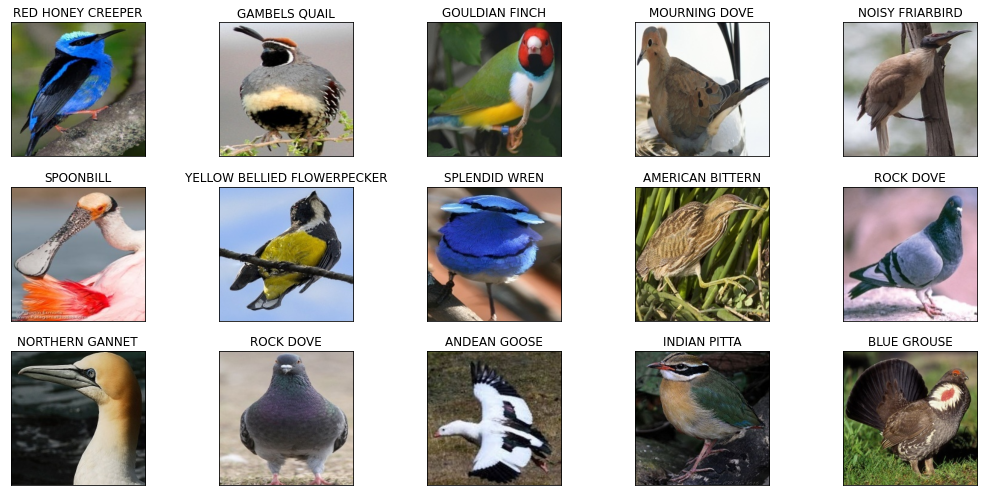

In [6]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

df_sample = df_train.sample(15)
df_sample.reset_index(drop=True, inplace=True)

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_sample.path[i]))
    ax.set_title(df_sample.label[i])
plt.tight_layout()
plt.show()

In [7]:
# Hyper Params
learning_rate = 0.01
num_classes = 400
batch_size = 20

In [8]:
transform_dict = transforms.Compose([transforms.Resize((120, 120)),
                                    transforms.RandomResizedCrop(120),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5],[0.4])
                                    ])

train_data = torchvision.datasets.ImageFolder(root=directories[1], transform=transform_dict)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4)

test_data = torchvision.datasets.ImageFolder(root=directories[0], transform=transform_dict)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4)

valid_data = torchvision.datasets.ImageFolder(root=directories[2], transform=transform_dict)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=5, shuffle=False, drop_last=False, num_workers=4)

In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*6*6, 256)
        self.fc2 = nn.Linear(256, 400)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.pool1(x))
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.pool2(x))

        x = x.view(-1,64*6*6)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [10]:
model = CNN(num_classes)

In [11]:
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
epochs = 20
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    model.cuda()
    for i, (batch, labels) in enumerate(train_loader):
        batch = batch.to(torch.device("cuda"))
        labels = labels.to(torch.device("cuda"))
        optimizer.zero_grad()
        y_pred =  model(batch)
        entropy_loss = nn.CrossEntropyLoss()
        loss = entropy_loss(y_pred,labels)
        loss.backward()
        optimizer.step()
      
        running_loss += loss.item()
        if i % 500 == 499:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 5.991
[1,  1000] loss: 5.980
[1,  1500] loss: 5.934
[1,  2000] loss: 5.848
[1,  2500] loss: 5.761
[2,   500] loss: 5.610
[2,  1000] loss: 5.535
[2,  1500] loss: 5.461
[2,  2000] loss: 5.407
[2,  2500] loss: 5.320
[3,   500] loss: 5.182
[3,  1000] loss: 5.121
[3,  1500] loss: 5.074
[3,  2000] loss: 5.061
[3,  2500] loss: 4.988
[4,   500] loss: 4.862
[4,  1000] loss: 4.845
[4,  1500] loss: 4.811
[4,  2000] loss: 4.794
[4,  2500] loss: 4.759
[5,   500] loss: 4.665
[5,  1000] loss: 4.643
[5,  1500] loss: 4.603
[5,  2000] loss: 4.570
[5,  2500] loss: 4.565
[6,   500] loss: 4.484
[6,  1000] loss: 4.444
[6,  1500] loss: 4.458
[6,  2000] loss: 4.423
[6,  2500] loss: 4.404
[7,   500] loss: 4.311
[7,  1000] loss: 4.288
[7,  1500] loss: 4.312
[7,  2000] loss: 4.295
[7,  2500] loss: 4.240
[8,   500] loss: 4.226
[8,  1000] loss: 4.174
[8,  1500] loss: 4.197
[8,  2000] loss: 4.155
[8,  2500] loss: 4.132
[9,   500] loss: 4.107
[9,  1000] loss: 4.087
[9,  1500] loss: 4.113
[9,  2000] 

In [13]:
PATH = "./model.pth"
torch.save(model.state_dict(), PATH)

In [14]:
model = CNN(num_classes)
model.load_state_dict(torch.load(PATH))

dataiter = iter(test_loader)
images, labels = dataiter.next()

outputs = model(images)

In [15]:
true = 0
total = 0
entropy_loss = nn.CrossEntropyLoss()

with torch.no_grad():
    for i, data in enumerate(valid_loader):
      images, labels = data

      outputs = model(images)
      loss = entropy_loss(outputs,labels)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      true += (predicted == labels).sum().item()

print('Accuracy of this network on validation images: %d %%' % (100 * true / total))

Accuracy of this network on validation images: 30 %
